In [1]:
import numpy as np
import pygame
import time
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.linear_model import LinearRegression
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def init_board():
    return np.zeros((6, 7))

In [3]:
def play_random(board):
    available = np.where(board[0, :] == 0)[0]
    return np.random.choice(available)

In [4]:
def play(board, col, value):
    pos = np.where(board[:, col] == 0)[0].max()
    board[pos, col] = value
    return board

In [5]:
def check_win(board):
    # Verificar filas
    for row in range(len(board) - 1, -1, -1):
        for col in range(len(board[row]) - 3):
            if (
                board[row][col]
                == board[row][col + 1]
                == board[row][col + 2]
                == board[row][col + 3]
                != 0
            ):
                return board[row][col]

    # Verificar columnas
    for col in range(len(board[0])):
        for row in range(len(board) - 3):
            if (
                board[row][col]
                == board[row + 1][col]
                == board[row + 2][col]
                == board[row + 3][col]
                != 0
            ):
                return board[row][col]

    # Verificar diagonales ascendentes
    for row in range(len(board) - 4, -1, -1):
        for col in range(len(board[row]) - 3):
            if (
                board[row][col]
                == board[row + 1][col + 1]
                == board[row + 2][col + 2]
                == board[row + 3][col + 3]
                != 0
            ):
                return board[row][col]

    # Verificar diagonales descendentes
    for row in range(len(board) - 1, 2, -1):
        for col in range(len(board[row]) - 3):
            if (
                board[row][col]
                == board[row - 1][col + 1]
                == board[row - 2][col + 2]
                == board[row - 3][col + 3]
                != 0
            ):
                return board[row][col]

    # Si no hay ganador, retornar None
    return 0

In [6]:
def logical_game(player_1, player_2):
    board = init_board()

    while True:
        col_1 = play_random(board)
        board = play(board, col_1, 1)

        winner = check_win(board)
        if winner:
            print(f"{player_1} ha ganado el juego.")
            print(board)
            return

        col_2 = play_random(board)
        board = play(board, col_2, -1)

        winner = check_win(board)
        if winner:
            print(f"{player_2} ha ganado el juego.")
            print(board)
            return

        if np.count_nonzero(board) == board.size:
            print("El juego ha terminado en empate.")
            print(board)
            return

In [7]:
def play_user(board):
    global screen
    selected_column = None
    done = False
    font = pygame.font.SysFont(None, 40)

    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
                return -1

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_1:
                    selected_column = 0
                    done = True
                elif event.key == pygame.K_2:
                    selected_column = 1
                    done = True
                elif event.key == pygame.K_3:
                    selected_column = 2
                    done = True
                elif event.key == pygame.K_4:
                    selected_column = 3
                    done = True
                elif event.key == pygame.K_5:
                    selected_column = 4
                    done = True
                elif event.key == pygame.K_6:
                    selected_column = 5
                    done = True
                elif event.key == pygame.K_7:
                    selected_column = 6
                    done = True

        if selected_column is not None:
            available_columns = np.where(board[0, :] == 0)[0]
            if selected_column in available_columns:
                return selected_column
            else:
                selected_column = None

        transparent_surface = pygame.Surface(
            (screen.get_width(), screen.get_height()), pygame.SRCALPHA
        )  # Crea una superficie transparente
        text = font.render("Chose a column (1 to 7):", True, (255, 255, 255))
        transparent_surface.blit(
            text, (10, 10)
        )  # Dibuja el texto en la superficie transparente
        screen.blit(
            transparent_surface, (0, 0)
        )  # Blit la superficie transparente en la pantalla
        pygame.display.flip()

In [8]:
def draw_board(board, screen, clock):
    SQUARE_SIZE = 480 / 6
    pygame.draw.rect(screen, (0, 0, 255), (0, 0, SQUARE_SIZE * 7, SQUARE_SIZE * 6))

    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if board[i, j] == 0:
                pygame.draw.circle(
                    screen,
                    (0, 0, 0),
                    (
                        int(j * SQUARE_SIZE + SQUARE_SIZE / 2),
                        int(i * SQUARE_SIZE + SQUARE_SIZE / 2),
                    ),
                    int(SQUARE_SIZE / 2 - 5),
                )
                # pygame.draw.circle(screen, (0, 255, 0), (j * SQUARE_SIZE, i * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
            if board[i, j] == 1:
                pygame.draw.circle(
                    screen,
                    (255, 255, 0),
                    (
                        int(j * SQUARE_SIZE + SQUARE_SIZE / 2),
                        int(i * SQUARE_SIZE + SQUARE_SIZE / 2),
                    ),
                    int(SQUARE_SIZE / 2 - 5),
                )
                # pygame.draw.circle(screen, (0, 255, 0), (j * SQUARE_SIZE, i * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
            if board[i, j] == -1:
                pygame.draw.circle(
                    screen,
                    (255, 0, 0),
                    (
                        int(j * SQUARE_SIZE + SQUARE_SIZE / 2),
                        int(i * SQUARE_SIZE + SQUARE_SIZE / 2),
                    ),
                    int(SQUARE_SIZE / 2 - 5),
                )
                # pygame.draw.circle(screen, (255, 0, 0), (j * SQUARE_SIZE, i * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
    pygame.display.flip()
    clock.tick(60)

In [9]:
def show_menu(screen):
    menu_text = "Select mode"
    pvp_text = "Player vs Player"
    pvc_text = "Player vs CPU"
    cvc_text = "CPU vs CPU"

    menu_font = pygame.font.Font("arial", 32)
    pvp_font = pygame.font.Font("arial", 24)
    pvc_font = pygame.font.Font("arial", 24)
    cvc_font = pygame.font.Font("arial", 24)

    while True:
        screen.fill((0, 0, 0))
        menu_surface = menu_font.render(menu_text, True, (255, 255, 0))
        pvp_surface = pvp_font.render(pvp_text, True, (255, 255, 0))
        pvc_surface = pvc_font.render(pvc_text, True, (255, 255, 0))
        cvc_surface = cvc_font.render(cvc_text, True, (255, 255, 0))

        menu_rect = menu_surface.get_rect()
        pvp_rect = pvp_surface.get_rect()
        pvc_rect = pvc_surface.get_rect()
        cvc_rect = cvc_surface.get_rect()

        menu_rect.midtop = (560 / 2, 50)
        pvp_rect.midtop = (560 / 2, 150)
        pvc_rect.midtop = (560 / 2, 200)
        cvc_rect.midtop = (560 / 2, 250)

        screen.blit(menu_surface, menu_rect)
        screen.blit(pvp_surface, pvp_rect)
        screen.blit(pvc_surface, pvc_rect)
        screen.blit(cvc_surface, cvc_rect)

        pygame.display.update()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if pvp_rect.collidepoint(event.pos):
                    start_game(1)
                elif pvc_rect.collidepoint(event.pos):
                    start_game(2)
                elif cvc_rect.collidepoint(event.pos):
                    start_game(3)

In [10]:
def to_string(board, col):
    flattened_board = board.flatten()
    array_strings = [str(element) for element in flattened_board]
    array_string = ",".join(array_strings)
    array_string_with_label = array_string + "," + str(col)
    return array_string_with_label

In [11]:
win_moves = []
loss_moves = []
tie_moves = []

In [12]:
def save_moves_csv(moves, filename):
    f = open(filename, "a")
    for line in moves:
        f.write(line)
        f.write("\n")
    f.close()

In [13]:
def logical_game_print(player_1, player_2):
    global win_moves, loss_moves, tie_moves
    board = init_board()
    moves_player1 = []
    moves_player2 = []

    while True:
        col_1 = player_1(board)
        s = to_string(board, col_1)
        moves_player1.append(s)
        board = play(board, col_1, 1)

        winner = check_win(board)
        if winner:
            # print(f"player_1 ha ganado el juego.")
            # print(board)
            save_moves_csv(moves_player1, "win.csv")
            save_moves_csv(moves_player2, "loss.csv")
            return 1

        col_2 = player_2(board)
        s = to_string(board, col_2)
        moves_player2.append(s)
        board = play(board, col_2, -1)
        # print(board)
        # print()

        winner = check_win(board)
        if winner:
            # print(f"player_2 ha ganado el juego.")
            # print(board)
            save_moves_csv(moves_player2, "win.csv")
            save_moves_csv(moves_player1, "loss.csv")
            return -1

        if np.count_nonzero(board) == board.size:
            # print("El juego ha terminado en empate.")
            # print(board)
            save_moves_csv(moves_player1 + moves_player2, "tie.csv")
            return 0


for games in range(100):
    logical_game_print(play_random, play_random)

In [14]:
import pygame


def logical_game_window(player_1, player_2):
    board = init_board()
    pygame.init()
    screen = pygame.display.set_mode((560, 480))
    clock = pygame.time.Clock()
    draw_board(board, screen, clock)

    while True:
        col_1 = player_1(board, screen)
        board = play(board, col_1, 1)
        draw_board(board, screen, clock)
        time.sleep(0.5)

        winner = check_win(board)
        if winner:
            draw_board(board, screen, clock)
            time.sleep(5)
            pygame.quit()
            print(f"player_1 ha ganado el juego.")
            print(board)
            return

        col_2 = player_2(board)
        board = play(board, col_2, -1)
        draw_board(board, screen, clock)
        time.sleep(0.5)

        winner = check_win(board)
        if winner:
            draw_board(board, screen, clock)

            time.sleep(5)
            pygame.quit()
            print(f"player_2 ha ganado el juego.")
            print(board)
            return

        if np.count_nonzero(board) == board.size:
            print("El juego ha terminado en empate.")
            print(board)
            return


logical_game_window(play_user, play_random)

player_1 ha ganado el juego.
[[ 1.  1.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.]]


In [80]:
class GameData(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.win_df = pd.read_csv("win.csv",  header=None)
        self.loss_df = pd.read_csv("loss.csv",  header=None)
        

    def __getitem__(self, i):
        if i < len(win_df):
            d = self.win_df.iloc[i]
            board = torch.tensor(d[:42], dtype=torch.float32)
            col = int(d[6*7])
            x = torch.zeros(7)
            x[col] = 1
        else:
            d = self.loss_df.iloc[i-len(win_df)]
            board = torch.tensor(d[:42], dtype=torch.float32)
            col = int(d[6*7])
            x = torch.ones(7)/6
            x[col] = 0
        return board, x

    def __len__(self):
        return len(win_df)+len(loss_df)

In [81]:
data_set_game = GameData()
dataset_loader = torch.utils.data.DataLoader(data_set_game, batch_size = 64, shuffle = True)

In [82]:
data_set_game[0], data_set_game[10], data_set_game[2500], 

((tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 1., 0., 0., 0., 0.])),
 (tensor([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0., -1.,  0., -1., -1., -1.,  0.,  0.,  1.,  1.,
          -1.,  1.,  1.,  0.,  0., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.]),
  tensor([0., 1., 0., 0., 0., 0., 0.])),
 (tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
           1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0., -1.,
          -1.,  1., -1., -1.,  0.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.]),
  tensor([0.1667, 0.1667, 0.0000, 0.1667, 0.1667, 0.1667, 0.1667])))

In [83]:
class Model(nn.Module):
    def __init__(self, hidden_size=200):
        super().__init__()
        self.layer1 = nn.Linear(42, hidden_size)
        self.layer2 = nn.Linear(hidden_size, 7)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.softmax(self.layer2(x))
        return x


net = Model()

In [86]:
opt = optim.Adam(net.parameters(), 0.0005)
loss_fn = nn.MSELoss()
losses = []

0 4.273731265217066
1 4.2595936469733715
2 4.252130564302206
3 4.248150836676359
4 4.243249371647835
5 4.239573001861572
6 4.236619368195534
7 4.235451631247997
8 4.232403516769409
9 4.230422791093588
10 4.227512687444687
11 4.223715055733919
12 4.2225568778812885
13 4.22009589523077
14 4.217462252825499
15 4.215771786868572
16 4.213455930352211
17 4.211146350950003
18 4.209987100213766
19 4.207372900098562


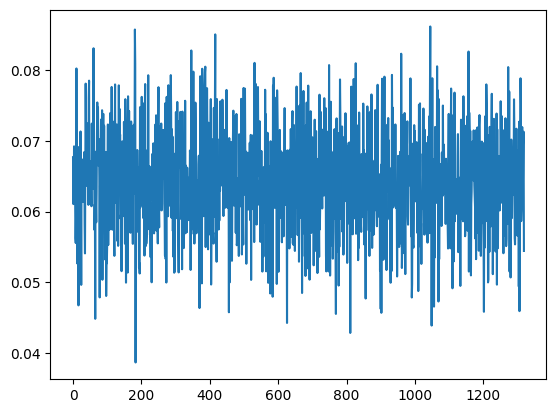

In [85]:
losses = []

for epoch in range(20):
    epoch_loss = 0
    for boards, outputs in dataset_loader:
        predictions = net(boards)
        loss = loss_fn(outputs, predictions)
        loss.backward()
        losses.append(loss.item())
        epoch_loss += loss.item()
        opt.step()
        opt.zero_grad()
    print(epoch, epoch_loss)

plt.plot(losses)
plt.show()

In [91]:
board = np.array([[0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., -1., 0., 0., 0.],
       [1., 0., 0., -1., 1., 1., 0.]])
board

array([[ 0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 1.,  0.,  0., -1.,  1.,  1.,  0.]])

In [130]:
flattened_board = board.flatten()
flatten_board_tensor = torch.tensor(flattened_board, dtype=torch.float32)[None,:]
output = net(flatten_board_tensor)
output_np = np.array(output.detach())
probas = ((board[0, :] == 0)*output_np)[0]
probas = probas/probas.sum()

np.random.choice(np.arange(7), p=probas)

6

In [131]:
def play_model1(board, net):
    flattened_board = board.flatten()
    flatten_board_tensor = torch.tensor(flattened_board, dtype=torch.float32)[None,:]
    output = net(flatten_board_tensor)
    output_np = np.array(output.detach())
    probas = ((board[0, :] == 0)*output_np)[0]
    probas = probas/probas.sum()

    return np.random.choice(np.arange(7), p=probas)
    